In [1]:
%matplotlib inline

# the below commands allow you to edit and reload pilotnet.py without 
# restarting the notebook kernel - use with caution!

# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 1

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Lambda, Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Input, Activation, add
from tensorflow.keras import regularizers

from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import os
import datetime
import glob
import time
import pandas as pd
from sklearn.model_selection import train_test_split

# some parameters and image preprocessing functions for pilotnet:
import utils

First collect data from the udacity simulator. The data collected will be used to train our model.

In [3]:
# CSV and jpgs from record

driving_data = [ "../training_data/driving_log.csv" 
                # additional cvs can be provided here
               ]
# count number of images
img_folder_name = "IMG" # make sure this is the correct file name for your image data location
img_folders = [os.path.join(os.path.dirname(log_file), img_folder_name) for log_file in driving_data] 
print(img_folders)
for f in img_folders:
    print(len(os.listdir(f)), " files found")

['../training_data/IMG']
9132  files found


This notebook will train an implementation of Nvidia's PilotNet using TensorFlow/Keras. As an exercise you should modify some or all of the following and compare against the baseline implementation here.

* Drop out probability
* Number of epochs  
* Samples per epoch  
* Batch size         
* Learning rate
* Model layers, outputs: e.g., add regularization, or speed prediction
* Image size (cropped or scaled)
* Image augmentation


Some comparison metrics:

* Can you drive faster than the baseline?
* Do you require less data to train? More?
* Model generalization:
    * Can your model be used on a different car? 
    * Can you slightly change the angle of the front camera at inference time?
    * Does the presence of people or lighting variations affect your model's performance?

Firt we will load in the data from the csv file and filter our all data where the car is stopped.
At the end we should have a set of images, input angles, and speeds which we will use to train the model.

In [4]:
imgs   = []
ngls   = []
speeds = []

for f in driving_data:
    data_df = pd.read_csv(f)
    data_df.columns = ['center', 'left', 'right', 'steering', 'throttle', '_', 'speed']

    f_imgs = data_df[['center', 'left', 'right']].values
    f_ngls = data_df['steering'].values
    f_speeds = data_df['speed']

    imgs.extend(f_imgs)
    ngls.extend(f_ngls)
    speeds.extend(f_speeds)

print("filtered data", len(imgs), len(ngls), len(speeds)) # the filtered data should all be the same size

filtered data 3043 3043 3043


These histograms of steering angles and speeds can be useful for sanity checking and considering what you should set `OFFSET_STEERING_ANGLE` to in `pilotnet.py` (which defines the magnitude of the pseudo-"corrective" steering angles applied to images taken from the left/right cameras during training below)

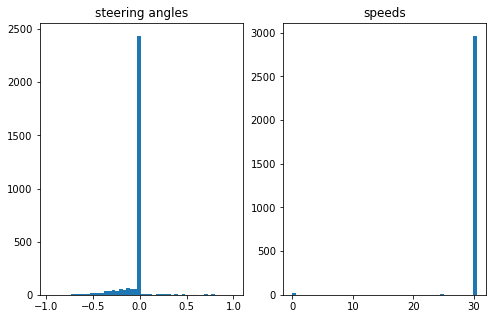

In [5]:
fig, ax = plt.subplots(ncols=2)
ax[0].hist(ngls, bins=50);
ax[1].hist(speeds, bins=50);
ax[0].set_title("steering angles")
ax[1].set_title("speeds")
fig.set_size_inches(8,5);

Let's look at an example image and see what the corresponding angle for that image. 
Does it look right?
Pay attention to the image size as this will be our input into the model.

angle: 0.000
image size: (160, 320, 3)


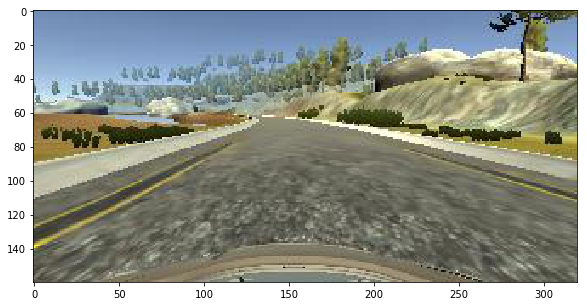

In [6]:
random_id = np.random.randint(0, len(imgs)-1)
random_img = imgs[random_id]
center_img = random_img[0]
img = cv.imread(center_img, cv.IMREAD_COLOR)

print("angle: {:02.3f}".format(ngls[random_id]))
print("image size:", img.shape)
rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
fig, ax = plt.subplots()
ax.imshow(rgb)
fig.set_size_inches(15,5);

## Image Augmentation

Here are some examples of image augmentation. One simply increases the brightness ("value" channel in the HSV colorspace), another perturbs the gamma value of the input image, and the third adds a random shadow. Try other augmentation techniques to increase the model's robustness. 

Note that it can take some experimentation to determine which augmentations help - some augmentation strategies might hurt performance. For instance, would it make sense to flip images horizontally or vertically?

If we flipped images horizontally, we would have to adjust the angles appropriately.

These techniques increase the size of our dataset to help generalize our trained model and improve robustness.

In [7]:

def random_flip(image, steering_angle):
    """
    Randomly flipt the image left <-> right, and adjust the steering angle.
    """
    if np.random.rand() < 0.5:
        image = cv.flip(image, 1)
        steering_angle = -steering_angle
    return image, steering_angle


def random_translate(image, steering_angle, range_x, range_y):
    """
    Randomly shift the image virtially and horizontally (translation).
    """
    trans_x = float(range_x) * (np.random.rand() - 0.5)
    trans_y = float(range_x) * (np.random.rand() - 0.5)
    steering_angle += trans_x * 0.002
    trans_m = np.float32([[1, 0, trans_x], [0, 1, trans_y]])
    height, width = image.shape[:2]
    image = cv.warpAffine(image, trans_m, (width, height))
    return image, steering_angle


def random_shadow(image):
    """
    Generates and adds random shadow
    """
    # (x1, y1) and (x2, y2) forms a line
    # xm, ym gives all the locations of the image
    x1, y1 = utils.IMAGE_WIDTH * np.random.rand(), 0
    x2, y2 = utils.IMAGE_WIDTH * np.random.rand(), utils.IMAGE_HEIGHT
    xm, ym = np.mgrid[0:utils.IMAGE_HEIGHT, 0:utils.IMAGE_WIDTH]

    # mathematically speaking, we want to set 1 below the line and zero otherwise
    # Our coordinate is up side down.  So, the above the line: 
    # (ym-y1)/(xm-x1) > (y2-y1)/(x2-x1)
    # as x2 == x1 causes zero-division problem, we'll write it in the below form:
    # (ym-y1)*(x2-x1) - (y2-y1)*(xm-x1) > 0
    mask = np.zeros_like(image[:, :, 1])
    mask[(ym - y1) * (x2 - x1) - (y2 - y1) * (xm - x1) > 0] = 1

    # choose which side should have shadow and adjust saturation
    cond = mask == np.random.randint(2)
    s_ratio = np.random.uniform(low=0.2, high=0.5)

    # adjust Saturation in HLS(Hue, Light, Saturation)
    hls = cv.cvtColor(image, cv.COLOR_RGB2HLS)
    hls[:, :, 1][cond] = hls[:, :, 1][cond] * s_ratio
    return cv.cvtColor(hls, cv.COLOR_HLS2RGB)


def random_brightness(image):
    """
    Randomly adjust brightness of the image.
    """
    # HSV (Hue, Saturation, Value) is also called HSB ('B' for Brightness).
    hsv = cv.cvtColor(image, cv.COLOR_RGB2HSV)
    ratio = 1.0 + 0.4 * (np.random.rand() - 0.5)
    hsv[:,:,2] =  hsv[:,:,2] * ratio
    return cv.cvtColor(hsv, cv.COLOR_HSV2RGB)

# change illumination using gamma correction
# https://stackoverflow.com/a/51174313
def make_random_gamma():
    random_gamma = np.random.normal(1, 0.3)
    random_gamma = np.clip(random_gamma, 0.5, 2)
    return random_gamma

def perturb_gamma(img): 
    gamma = make_random_gamma()
    invGamma = 1.0 / gamma
    table = np.array([
        ((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)])
    return cv.LUT(img, table.astype(np.uint8))


Let's visualize the distribution of random gamma perturbations

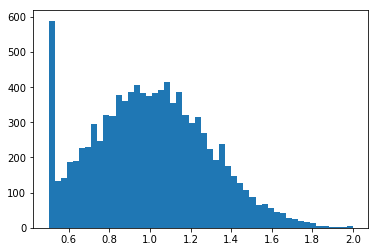

In [8]:
rg = [make_random_gamma() for i in range(10000)]
plt.hist(rg, bins=50);

random brighness


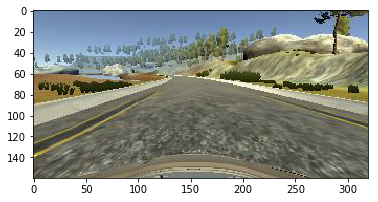

In [9]:
# visualize the effects of augmentation
q = np.copy(rgb)
qbgr = cv.cvtColor(q, cv.COLOR_RGB2BGR)
if np.random.random() < 0.5:
    print("random brighness")
    qbgr = random_brightness(qbgr)
else:
    print("random gamma")
    qbgr = perturb_gamma(qbgr)
q = cv.cvtColor(qbgr, cv.COLOR_BGR2RGB)
plt.imshow(q)

Split the data into training and validation subsets. Optionally randomize order and/or use a fixed seed:

In [10]:
VAL_SIZE_FRACTION = 0.15
SEED = 56709 #awoo

X_train, X_valid, y_train, y_valid = train_test_split(imgs, ngls, test_size=VAL_SIZE_FRACTION, shuffle=False) #,random_state=SEED)

print(len(X_train), len(X_valid))

2586 457


In [11]:
def build_model(dropout_rate=0.5):
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5-1.0, input_shape=utils.INPUT_SHAPE)) #normalize the data
    model.add(Conv2D(24, (5,5), strides=(2, 2), activation='elu'))
    model.add(Conv2D(36, (5,5), strides=(2, 2), activation='elu'))
    model.add(Conv2D(48, (5,5), strides=(2, 2), activation='elu'))
    model.add(Conv2D(64, (3,3), activation='elu'))
    model.add(Conv2D(64, (3,3), activation='elu'))
    model.add(Dropout(dropout_rate)) 
    model.add(Flatten())
    model.add(Dense(100, activation='elu'))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))
    model.add(Dense(1))
    model.summary() # prints out the model description
    return model

model = build_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 66, 200, 3)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout (Dropout)            (None, 1, 18, 64)         0         
__________

In [12]:
learning_rate = 1.0e-4 # tunable parameter

MODEL_NAME = "model_{}_".format(datetime.datetime.now().strftime("%m_%d_%H_%M")) 

model.compile(loss='mean_squared_error', optimizer=Adam(lr=learning_rate))

# can change to saving all models or just the best using save_best_only
checkpoint = ModelCheckpoint(MODEL_NAME + '{epoch:03d}.h5',
                             monitor='val_loss',
                             verbose=0,
                             save_best_only=True,
                             mode='auto')

In [13]:
# Play around with which augmentation tricks you use!
def augment(image, steering_angle, range_x=100, range_y=10):
    """
    Generate an augmented image and adjust steering angle.
    (The steering angle is associated with the center image)
    """    
    image, steering_angle = random_flip(image, steering_angle)
    image, steering_angle = random_translate(image, steering_angle, range_x, range_y)
    image = random_shadow(image)
    image = random_brightness(image)
    return image, steering_angle

In [14]:
def batch_generator(image_paths, steering_angles, batch_size, is_training):
    """
    Generate training image give image paths and associated steering angles
    """
    images = np.empty([batch_size, utils.IMAGE_HEIGHT, utils.IMAGE_WIDTH, utils.IMAGE_CHANNELS])
    steers = np.empty(batch_size)
    while True:
        i = 0
        for index in np.random.permutation(len(image_paths)):
            center, left, right = image_paths[index]
            steering_angle = steering_angles[index]

            image, steering_angle = utils.preprocess_multiple(center, left, right, steering_angle)
            # argumentation
            if is_training and np.random.rand() < 0.6:
                image, steering_angle = augment(image, steering_angle)

            # add the image and steering angle to the batch
            images[i] = image
            steers[i] = steering_angle
            i += 1
            if i == batch_size:
                break
        yield images, steers

Visualize distribution of steering angles in training and validation sets.

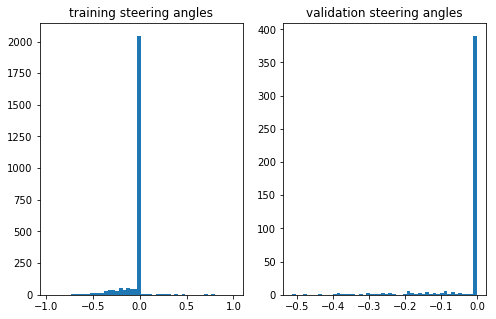

In [15]:
fig, ax = plt.subplots(ncols=2)
ax[0].hist(y_train, bins=50);
ax[0].set_title("training steering angles")
ax[1].hist(y_valid, bins=50);
ax[1].set_title("validation steering angles")
fig.set_size_inches(8,5);

# Training

Note that comparing training and validation loss is not a perfect measurement of how your simulation will perform in the simulator. Solely using mean squared error on steering angles is perhaps a crude accuracy metric on this task. Also note that if you are not augmenting your validation data (and if your augmentations are not characteristic of the validation data), then the training and validation losses may be tough to compare.

Can you develop some more robust testing metrics for your model's performance?

In [16]:
# tunable parameters
BATCH_SIZE=20 
STEPS_PER_EPOCH = 50
NUM_EPOCHS = 10

model.fit_generator(batch_generator(X_train, y_train, batch_size=BATCH_SIZE, is_training=True),
                        steps_per_epoch=STEPS_PER_EPOCH,
                        epochs=NUM_EPOCHS,
                        validation_data=batch_generator(X_valid, y_valid, BATCH_SIZE, False),
                        validation_steps=len(X_valid) // BATCH_SIZE,
                        callbacks=[checkpoint],
                        verbose=1)

Epoch 1/10
16/50 [========>.....................] - ETA: 25s - loss: 0.1787

KeyboardInterrupt: 